In [20]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

In [9]:
emissions = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv", skiprows=3)
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")

# processing the temperature dataset to only show Indonesia
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
indo_temp = country.loc[country["Country"] == "Indonesia"] 
indo_temp.fillna(method="bfill", inplace=True)
indo_temp.drop("AverageTemperatureUncertainty", axis=1, inplace=True)
indo_temp = indo_temp.resample("AS").mean()
indo_temp 

# processing the CO2 emissions dataset to only show Indonesia
indo_emissions = emissions.loc[emissions["Country Name"] == "Indonesia"]
indo_emissions.drop("Unnamed: 65", axis=1, inplace=True)
# dropping the NaN values as it doesn't affect the analysis
indo_emissions.drop(["2019", "2020"], axis=1, inplace=True)

# slicing the dataframe to get usable features
indo_emissions = indo_emissions.iloc[:, 4:]
indo_emissions = indo_emissions.transpose()
indo_emissions.rename(columns={106:"CO2 emissions (metric tons per capita)"}, inplace=True)
indo_emissions.index = pd.to_datetime(indo_emissions.index)
 
# combining the two datasets together
# drop rows that don't have both features
indo_final = indo_temp.merge(indo_emissions, how='inner', left_on=indo_temp.index, right_on=indo_emissions.index)

# changing the datetime column name
indo_final.rename(columns={"key_0":"datetime"}, inplace=True)
indo_final

# setting the date to be the index
indo_final.set_index("datetime", inplace=True)
indo_final

,AverageTemperature,CO2 emissions (metric tons per capita)
datetime,,
1960-01-01,26.029167,0.243920
1961-01-01,25.771667,0.288848
1962-01-01,25.789417,0.248553
1963-01-01,25.838583,0.239783
1964-01-01,25.835500,0.229458
1965-01-01,25.701750,0.246241
1966-01-01,25.943917,0.227084
1967-01-01,25.835083,0.232007
1968-01-01,25.951083,0.253602


In [36]:
# splitting the data into train and test (last 10 years will be testing data)
nobs = 10
df_train, df_test = indo_final[0:-nobs], indo_final[-nobs:] 

# checking the size
print(df_train.shape)
print(df_test.shape)

(44, 2)
(10, 2)


In [17]:
# since the missing values have been dealt with, proceed to significant connection between the emission and temp
# using the coint-johansen test to determine to check the cointegration
def cointegration_test(df, alpha=0.05):
    """ Perform cointegration test and return summary"""
    out = coint_johansen(df, -1, 5)
    d = {"0.90":0, "0.95":1, "0.99":2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt) 

cointegration_test(indo_final)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AverageTemperature ::  9.43      > 12.3212   =>   False
CO2 emissions (metric tons per capita) ::  0.81      > 4.1296    =>   False


In [11]:
# checking the causation of the CO2 emission time series on the Average Temperature time series
# Using the Granger Causality test
maxlag = 12
def granger_test(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows -> response variable, columns -> predictors. The values in the table -> p-values
    p-value threshold -> 5%, p-values lesser than the threshold implies that the null-hypothesis is rejected
    means that there is causality between the time series
    """

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_test(indo_final, variables=indo_final.columns)


,AverageTemperature_x,CO2 emissions (metric tons per capita)_x
AverageTemperature_y,1.0000,0.0
CO2 emissions (metric tons per capita)_y,0.0001,1.0


In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [22]:
# calling the test on each series
for name, column in indo_final.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "AverageTemperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.294
 No. Lags Chosen       = 3
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.6319. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CO2 emissions (metric tons per capita)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.4326
 No. Lags Chosen       = 3
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.9973. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [24]:
# differencing the series and then retrying the test
indo_final_differenced = indo_final.diff().fillna(method="bfill")
for name, column in indo_final_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "AverageTemperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3476
 No. Lags Chosen       = 2
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO2 emissions (metric tons per capita)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9851
 No. Lags Chosen       = 2
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [29]:
# Series become stationary after one order of differencing
# Selecting the order of the VAR model
model = VAR(indo_final_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print("Lag Order =", i)
    print("AIC : ", result.aic)
    print("BIC : ", result.bic) 
    print("FPE : ", result.fpe)
    print("HQIC : ", result.hqic, "\n")


Lag Order = 1
AIC :  -8.958651614394183
BIC :  -8.735599699652434
FPE :  0.00012865073087774224
HQIC :  -8.872876605671639 

Lag Order = 2
AIC :  -9.033150264415406
BIC :  -8.657911087765132
FPE :  0.00011952818976682947
HQIC :  -8.889292420255039 

Lag Order = 3
AIC :  -9.038239827043475
BIC :  -8.507934751393659
FPE :  0.00011919465062700161
HQIC :  -8.835594572985347 

Lag Order = 4
AIC :  -9.0285840315289
BIC :  -8.34025574957477
FPE :  0.00012088712764230535
HQIC :  -8.766464695849221 

Lag Order = 5
AIC :  -8.957443359650833
BIC :  -8.108054654376675
FPE :  0.00013079416391376832
HQIC :  -8.635186469649165 

Lag Order = 6
AIC :  -8.84189636744699
BIC :  -7.828329153205217
FPE :  0.00014861104588835444
HQIC :  -8.458867836678477 

Lag Order = 7
AIC :  -8.697141442892127
BIC :  -7.516196165204855
FPE :  0.00017496226723621444
HQIC :  -8.252743801609597 

Lag Order = 8
AIC :  -8.616409966783923
BIC :  -7.264805456335461
FPE :  0.00019490602404509229
HQIC :  -8.110090816397225 

Lag 

In [31]:
# training the model to the third lag order
model_fit = model.fit(3)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     11:49:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.50793
Nobs:                     51.0000    HQIC:                  -8.83559
Log likelihood:           99.7434    FPE:                0.000119195
AIC:                     -9.03824    Det(Omega_mle):     9.21597e-05
--------------------------------------------------------------------
Results for equation AverageTemperature
                                               coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------
const                                            -0.014597         0.036675           -0.398           0.691
L1.AverageTemperature                       

In [41]:
# getting the lag order for forecasting
lag_order = model_fit.k_ar

# forecasting input data
forecast_input = indo_final_differenced.values[-lag_order:]

# begin forecasting
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=indo_final_differenced.index[-nobs:], columns=indo_final_differenced.columns + "_1d")
df_forecast

,AverageTemperature_1d,CO2 emissions (metric tons per capita)_1d
datetime,,
2004-01-01,0.039384,-0.031370
2005-01-01,-0.177259,0.073098
2006-01-01,-0.056032,0.091191
2007-01-01,0.121026,0.036634
2008-01-01,0.067480,0.011155
2009-01-01,-0.029400,0.017822
2010-01-01,-0.031587,0.031774
2011-01-01,0.023059,0.035182
2012-01-01,0.025783,0.033629


In [47]:
# inverting the difference to get the actual forecasting
def inverse_difference(df_train, df_forecast):
    """Integrating the differenced dataset"""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back first diff
        df_fc[str(col) + "_forecast"] = df_train[col].iloc[-1] + df_fc[str(col)+"_1d"]
    return df_fc

In [50]:
# getting the actual forecast results
df_results = inverse_difference(df_train, df_forecast)
df_results.loc[:, ["AverageTemperature_forecast", "CO2 emissions (metric tons per capita)_forecast"]]

,AverageTemperature_forecast,CO2 emissions (metric tons per capita)_forecast
datetime,,
2004-01-01,26.484884,1.490897
2005-01-01,26.268241,1.595366
2006-01-01,26.389468,1.613459
2007-01-01,26.566526,1.558902
2008-01-01,26.512980,1.533423
2009-01-01,26.416100,1.540089
2010-01-01,26.413913,1.554042
2011-01-01,26.468559,1.557450
2012-01-01,26.471283,1.555896


In [56]:
# comparing the forecast results to the actual results
indo_final[-nobs:]

,AverageTemperature,CO2 emissions (metric tons per capita)
datetime,,
2004-01-01,26.434833,1.536865
2005-01-01,26.453750,1.521944
2006-01-01,26.381750,1.587750
2007-01-01,26.293083,1.635207
2008-01-01,26.065250,1.601819
2009-01-01,26.455000,1.653210
2010-01-01,26.537000,1.724074
2011-01-01,26.202250,1.960133
2012-01-01,26.322083,1.959133


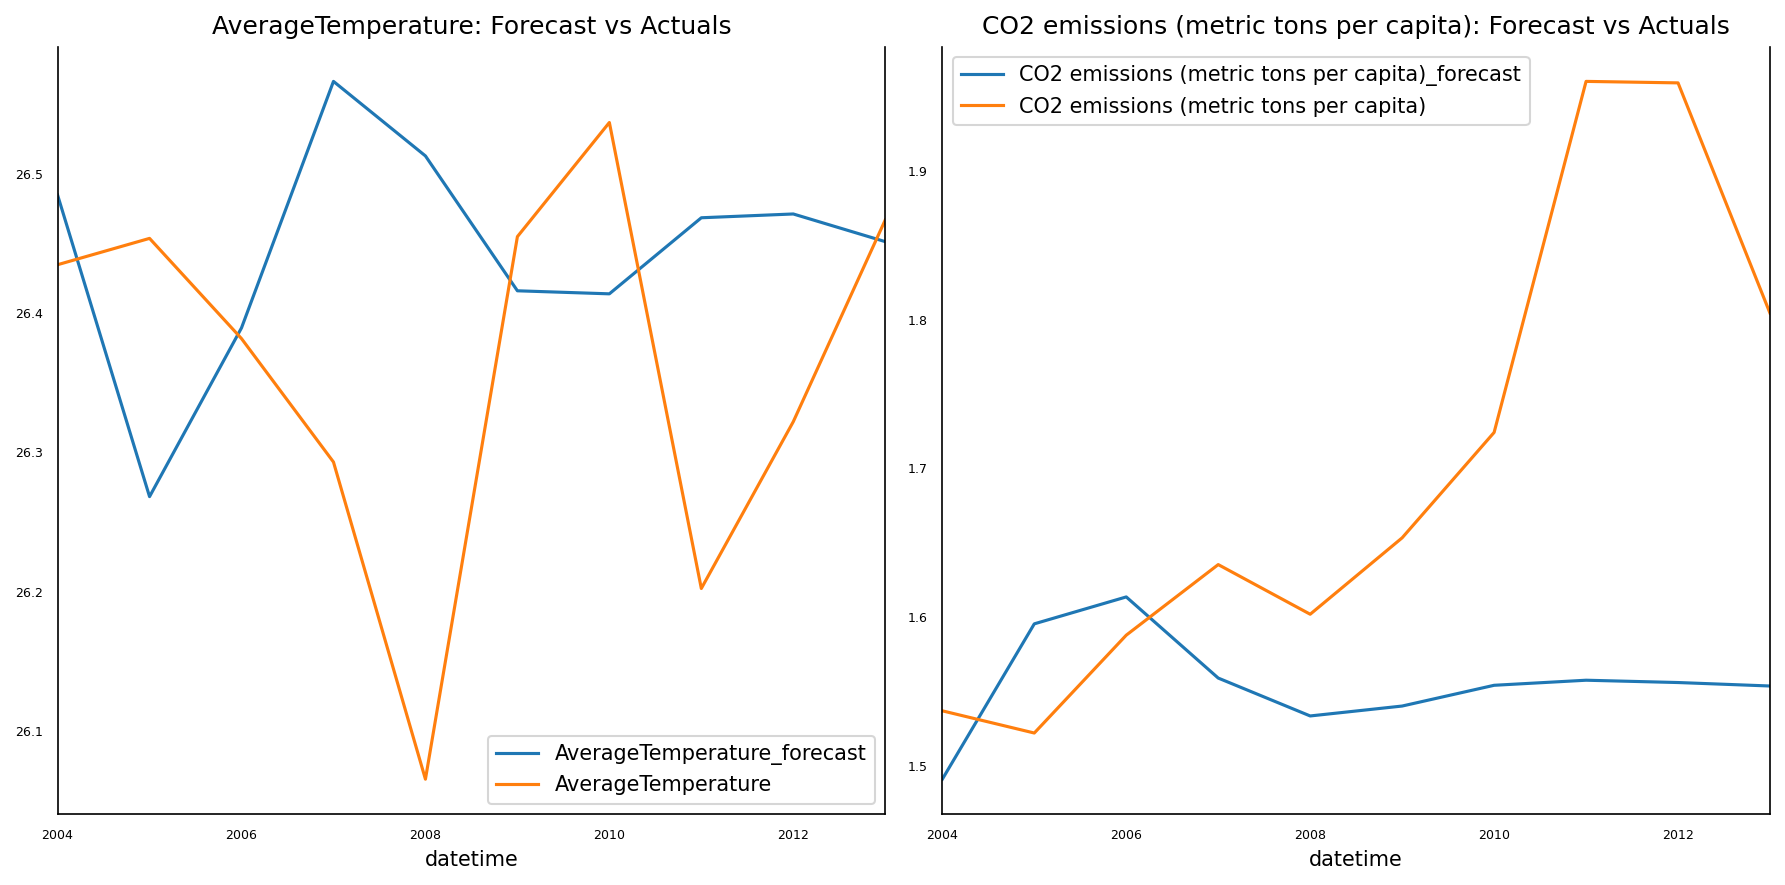

In [55]:
fig, axes = plt.subplots(nrows=int(len(indo_final.columns)/2), ncols=2, dpi=150, figsize=(12, 6))
for i, (col,ax) in enumerate(zip(indo_final.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();